<a href="https://colab.research.google.com/github/arthijayaraman-lab/CREASE-2D/blob/main/CREASE%20Tutorials/Calculate_1D_Scattering_Profiles_from_3D_Structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Change Runtime Environment to use GPUs in Colab while running.
  - Runtime > Change runtime type > Hardware accelarator - T4 GPU.



In [1]:
#@title Download Requirements
!pip install cupy-cuda12x

In [2]:
#@title Import Required libraries
import os
import numpy as np
import pickle
from scipy.special import erfcinv
from scipy.special import i0, i1
from scipy.interpolate import interp1d
import sys
import pandas as pd
import glob
import plotly.express as px
import matplotlib.pyplot as plt
import math
import cupy as cp
from time import time
from time import perf_counter

Input file already exists at: /content/sample_scatterers.dump
Parsing file: /content/sample_scatterers.dump
Found number_of_atoms: 288956
Box bounds:
[[-50.  50.]
 [-50.  50.]
 [-50.  50.]]
Number of batches: 1
Elapsed time: 8.54515232099999 seconds
Finished processing /content/sample_scatterers.dump. Output saved to /content/output/sample_1D_profile.dump.


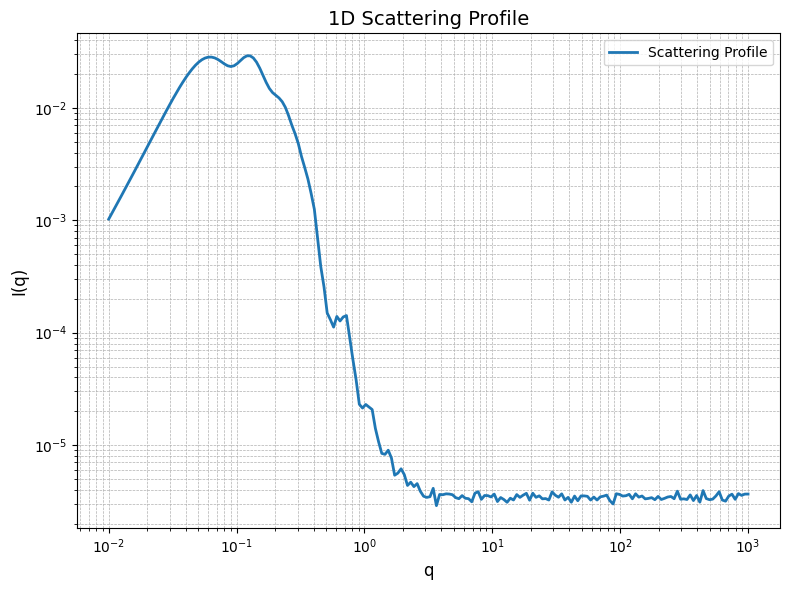

In [6]:
#@title Calculate 1D scattering profile from 3D structure

def fibonacci_sphere(samples=1000, direction=[0, 1, 0]):
    """
    Generate points on a sphere's surface using a Fibonacci spiral algorithm.
    This provides a uniform distribution of directions.
    """
    phi = cp.pi * (3. - cp.sqrt(5.))  # golden angle in radians
    if samples == 1:
        point = cp.array([direction])
        return point / cp.linalg.norm(point, axis=1)

    indices = cp.arange(samples)
    y = 1 - (indices / (samples - 1)) * 2
    radius = cp.sqrt(1 - y * y)
    theta = phi * indices
    x = cp.cos(theta) * radius
    z = cp.sin(theta) * radius
    points = cp.column_stack((x, y, z))
    return points

def single_loop_minus_box(qrange, len_box, box_shift, coords, apply_center_correction=False, direction=[0, 1, 0], total_points=300):
    """
    Compute 1D scattering profile from 3D structure.
    """
    points = cp.asarray(coords)  # shape (N, 3)
    v_array = cp.asarray(fibonacci_sphere(total_points, direction).T)  # shape (3, total_points)
    q_range_cp = cp.asarray(qrange)
    if apply_center_correction:
        points = points - cp.asarray(box_shift)

    num_points = points.shape[0]
    num_q = q_range_cp.size
    num_dirs = v_array.shape[1]

    ret = cp.zeros((num_q, num_dirs), dtype=cp.float32)

    start_time = perf_counter()
    batch_size = num_points
    num_batches = (num_points + batch_size - 1) // batch_size
    print(f"Number of batches: {num_batches}")
    sum_exp = cp.zeros((num_dirs,), dtype=cp.complex64)

    # Main loop over q
    for qi in range(num_q):
        q = q_range_cp[qi]
        q_vecs = q * v_array  # shape (3, num_dirs)

        sum_exp[:] = 0+0j

        for batch in range(num_batches):
            start = batch * batch_size
            end = min((batch + 1) * batch_size, num_points)
            r_batch = points[start:end]  # shape (batch_size, 3)
            rvqs = cp.matmul(r_batch, q_vecs)  # shape (batch_size, num_dirs)
            sum_exp += cp.exp(-1j * rvqs).sum(axis=0)

        # Box form factor
        qx = q_vecs[0]
        qy = q_vecs[1]
        qz = q_vecs[2]
        # Using np.sinc:
        box_ff = cp.sinc(qx * len_box[0] / (2 * cp.pi)) * \
                 cp.sinc(qy * len_box[1] / (2 * cp.pi)) * \
                 cp.sinc(qz * len_box[2] / (2 * cp.pi))

        sum_exp = sum_exp / num_points - box_ff
        intensity = cp.real(sum_exp * cp.conj(sum_exp))
        ret[qi, :] = intensity

    omega = ret.mean(axis=1)
    end_time = perf_counter()
    print("Elapsed time:", end_time - start_time, "seconds")
    return omega

def parse_lammps(input_file):
    number_of_atoms = None
    box_bounds = None
    atoms_data = []
    with open(input_file,'r') as  file:
        while True:
            line = file.readline()
            if not line:
                break
            line_strp = line.strip()
            if line_strp.startswith("ITEM: NUMBER OF ATOMS"):
                num_atoms_line = file.readline().strip()
                number_of_atoms = int(num_atoms_line)

            elif line_strp.startswith("ITEM: BOX BOUNDS"):
                bounds = []
                for _ in range(3):
                    bounds_line = file.readline().strip().split()
                    bounds.append(list(map(float, bounds_line)))
                box_bounds = np.array(bounds)

            elif line_strp.startswith("ITEM: ATOMS"):
                for _ in range(number_of_atoms):
                    atom_line = file.readline().strip().split()
                    # Convert to float
                    atom_data = list(map(float, atom_line))
                    atoms_data.append(atom_data)
                break
    columns = ['id','mol', 'type', 'x', 'y', 'z']
    df = pd.DataFrame(atoms_data, columns=columns)
    return number_of_atoms,box_bounds,df


if __name__ == '__main__':
    # User-defined parameters
    input_file = '/content/sample_scatterers.dump'
    print(f"Downloading input file...")
    if not os.path.isfile(input_file):
      print(f"Downloading input file to: {input_file}")
      !wget -O {input_file} https://raw.githubusercontent.com/arthijayaraman-lab/CREASE-2D/main/CREASE%20Tutorials/sample_scatterers.dump
    else:
      print(f"Input file already exists at: {input_file}")

    output_dir = '/content/output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print(f"Parsing file: {input_file}")
    number_of_atoms, box_bounds, df = parse_lammps(input_file)
    print(f"Found number_of_atoms: {number_of_atoms}")
    print(f"Box bounds:\n{box_bounds}")
    pts = np.column_stack((df['x'].values, df['y'].values, df['z'].values))

    len_box = box_bounds[:, 1] - box_bounds[:, 0]
    box_shift = len_box / 2.0

    # q_range
    q_range = cp.logspace(-2, 3, 200)

    # Compute scattering profile
    omega = single_loop_minus_box(q_range, len_box, box_shift, pts,apply_center_correction=False)

    # Save results
    base_file_name = os.path.basename(input_file)
    output_file_name = base_file_name.replace('_scatterers', '_1D_profile')
    output_file_path = os.path.join(output_dir, output_file_name)

    with open(output_file_path, 'w') as output_file:
        for i in range(len(q_range)):
            output_file.write(f"{q_range[i]} {omega[i]}\n")

    print(f"Finished processing {input_file}. Output saved to {output_file_path}.")

output_file_path = '/content/output/sample_1D_profile.dump'
data = cp.loadtxt(output_file_path)
q_values = data[:, 0]
omega_values = data[:, 1]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(q_values.get(), omega_values.get(), label="Scattering Profile", linewidth=2)
plt.xscale('log')  # Log scale for q-axis
plt.yscale('log')  # Log scale for intensity
plt.xlabel('q', fontsize=12)
plt.ylabel('I(q)', fontsize=12)
plt.title('1D Scattering Profile', fontsize=14)
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
